In [1]:
import os
import warnings

os.environ['PYTHONWARNINGS'] = "ignore:Unverified HTTPS request"
warnings.filterwarnings("ignore")

import pandas as pd
import sqlite3
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from pandasql import sqldf
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
pysqldf = lambda q: sqldf(q, globals())

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
### import data
df_master = pd.read_excel('Navigation_rawdata.xlsx', parse_dates=['rtimestamp'])

In [5]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain
0,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:54.310000+00:00,external_access,android native,NaN,NaN
1,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:56.467000+00:00,product_list_search,android native,NaN,NaN
2,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:58.620000+00:00,product_view,android native,80089006.0,Fashion & Lifestyle
3,05bb3946-4bb4-4e1f-a04b-ba16522893c2,NaT,exit,android native,NaN,NaN
4,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:21:07.545000+00:00,product_list_search,desktop,NaN,NaN


In [6]:
df_master.shape

(833538, 6)

#### Data understanding

There is null values for rtimestamp,buyingcategoryid, domain

In [7]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833538 entries, 0 to 833537
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   sessionid         833538 non-null  object             
 1   rtimestamp        792553 non-null  datetime64[ns, UTC]
 2   event_type        833538 non-null  object             
 3   channel           833538 non-null  object             
 4   buyingcategoryid  202254 non-null  float64            
 5   domain            202248 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 38.2+ MB


There is dublicated rows for sessionid

In [8]:
df_master.sessionid.nunique()

40000

Sessionid can make couple of processes throughout time 

In [9]:
des_df=df_master.groupby('sessionid')['channel'].count().reset_index()

In [10]:
des_df.head()

,sessionid,channel
0,00000221-c499-4158-967d-cf8efe956e66,15
1,00000270-cadc-4dec-a188-0634f74aebf9,5
2,00000e40-d6d9-4568-bd34-74c283694341,4
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,2
4,000016ff-1ee3-41bc-9061-525e3184f74d,3


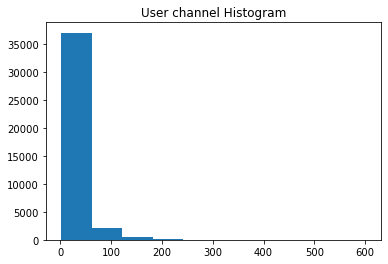

In [11]:
plt.hist(des_df.channel)
plt.title("User channel Histogram") 

plt.show()

There is widespread range between processes of sessions 

In [12]:
print(des_df.channel.min(),des_df.channel.max())

2 601


In [13]:
des_df.channel.value_counts(normalize=True,dropna=False)

2      0.138350
3      0.096575
4      0.059025
5      0.049100
6      0.042200
7      0.036000
9      0.031575
8      0.029675
10     0.027375
11     0.025225
12     0.023050
14     0.021650
13     0.020750
15     0.019125
17     0.017425
16     0.017425
18     0.015575
19     0.015325
20     0.013825
21     0.013125
22     0.012700
23     0.011350
24     0.010950
26     0.009975
25     0.009775
27     0.009175
28     0.008875
29     0.007950
31     0.007750
30     0.007600
32     0.006825
34     0.006625
33     0.006600
36     0.006150
35     0.006050
38     0.005800
37     0.005625
39     0.005200
41     0.004950
40     0.004425
44     0.004325
42     0.004250
45     0.003850
50     0.003800
43     0.003775
46     0.003675
48     0.003375
47     0.003200
49     0.003200
51     0.002975
52     0.002925
53     0.002900
56     0.002825
57     0.002550
54     0.002550
60     0.002400
65     0.002300
55     0.002275
58     0.002100
61     0.002075
66     0.002050
63     0.002000
62     0

Let's look at the boxplot and distribution

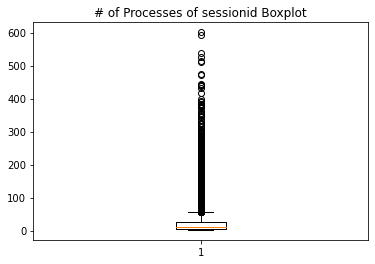

In [14]:
plt.boxplot(des_df.channel)
plt.title("# of Processes of sessionid Boxplot") 
plt.show()

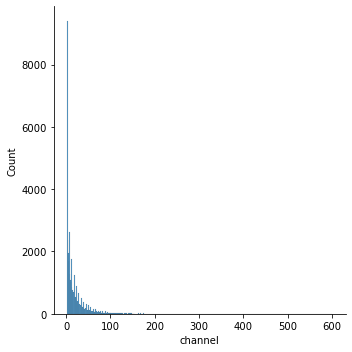

In [15]:
sns.displot(des_df.channel)
plt.show()

Boxplot shows that we have lots of outliers. However, There is one peak around zero. It is channel number of 2 as seen on the value_counts above. Most of the the data lies between 0-40 anyways so let's see how is the distribution between channel number 0 and 100.

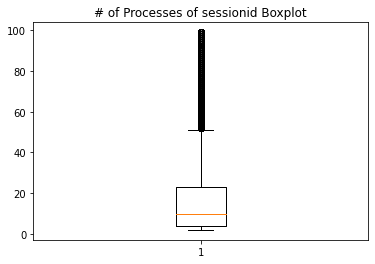

In [16]:
plt.boxplot(des_df[(des_df.channel<100)]['channel'])
plt.title("# of Processes of sessionid Boxplot") 
plt.show()

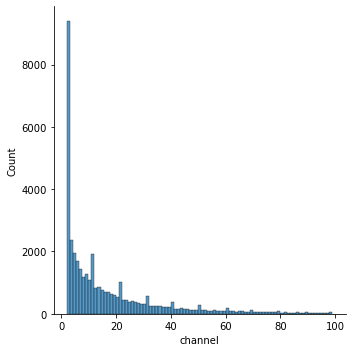

In [17]:
sns.displot(des_df[(des_df.channel<100)]['channel'])
plt.show()

In [18]:
len(des_df[(des_df.channel<40)]['channel'])/len(des_df)

0.85735

In [19]:
len(des_df[(des_df.channel<80)]['channel'])/len(des_df)

0.955825

In [20]:
len(des_df[(des_df.channel<100)]['channel'])/len(des_df)

0.972725

Finally we have smoother distribution on user channel. It also contains around 97% percent of all users' # of processes info. Actually, we cannot use the channel number directly as a continous variable because we dont know at the begining. It is generated based on historical data

In [21]:
print(df_master.rtimestamp.min(),df_master.rtimestamp.max())

2021-03-13 17:08:37.580000+00:00 2021-12-15 10:05:32.191000+00:00


We are good with the NAs except for buyingcategoryid and domain. We have 75% of NA values on them respectively.

In [22]:
df_master.isna().mean()

sessionid           0.000000
rtimestamp          0.049170
event_type          0.000000
channel             0.000000
buyingcategoryid    0.757355
domain              0.757362
dtype: float64

In [23]:
df_master.event_type.value_counts(dropna=False)

product_view             154380
basket_view              149309
product_list_search      115577
home                      83901
product_list_tag          65028
addtocart                 48266
product_list_category     42080
exit                      40985
ordertracking             25993
order_result              21210
campaigns                 20077
product_list_merchant     15822
mylist                    13940
external_access           11991
product_list_brand        10622
wallet_view                4129
category_list              3896
hepsi_express              2747
account_info                768
claim_tracking              748
solution_center             397
my_gift_cheques             391
destek_taleplerim           385
efsaneler_klubu             381
dealofday                   263
my_product_comments         210
product_compare              42
Name: event_type, dtype: int64

There are categorical variables for buyingcategoryid. We will predict through an upper-level. So, let's get some features on event_type level rather than dealing with it by imputing through upper-level category.

Having a group to event_type mapping is always a good idea. We can utilize the transactions by that.

In [24]:
#df_group_content_mapping = df_master[['event_type','buyingcategoryid']].copy()

buyingcategoryid correctly represents domain column

In [25]:
df_master[(~df_master.buyingcategoryid.isna())].groupby('buyingcategoryid')['domain'].nunique().reset_index()

,buyingcategoryid,domain
0,80087001.0,1
1,80089001.0,1
2,80089002.0,1
3,80089003.0,1
4,80089005.0,1
5,80089006.0,1
6,80089007.0,1
7,80089008.0,1
8,80089009.0,1
9,80089012.0,1


In [26]:
df_master[(~df_master.buyingcategoryid.isna()) & (df_master.domain.isna())].head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain
259117,098fd7d6-6322-44f7-9344-e709d3dd962b,2021-12-12 13:03:04.131000+00:00,product_view,desktop,80822005.0,NaN
259118,098fd7d6-6322-44f7-9344-e709d3dd962b,2021-12-12 13:03:41.674000+00:00,product_view,desktop,80822005.0,NaN
287452,0a104169-c480-4c3e-9d05-4dd7f739f22b,2021-12-06 20:25:06.298000+00:00,product_view,desktop,80822005.0,NaN
412592,072e6315-8c39-4d38-90b6-01f95ba6ae1c,2021-12-08 10:59:21.459000+00:00,product_view,desktop,80822005.0,NaN
816140,5381af1b-9e48-4fa3-bfa0-a38b7e61ad9e,2021-12-07 18:15:11.508000+00:00,product_view,desktop,80822005.0,NaN


In [27]:
df_master[(df_master.buyingcategoryid.isna()) & (~df_master.domain.isna())].head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain


In [28]:
df_master[df_master.buyingcategoryid == 80822005.0]

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,domain
259117,098fd7d6-6322-44f7-9344-e709d3dd962b,2021-12-12 13:03:04.131000+00:00,product_view,desktop,80822005.0,NaN
259118,098fd7d6-6322-44f7-9344-e709d3dd962b,2021-12-12 13:03:41.674000+00:00,product_view,desktop,80822005.0,NaN
287452,0a104169-c480-4c3e-9d05-4dd7f739f22b,2021-12-06 20:25:06.298000+00:00,product_view,desktop,80822005.0,NaN
412592,072e6315-8c39-4d38-90b6-01f95ba6ae1c,2021-12-08 10:59:21.459000+00:00,product_view,desktop,80822005.0,NaN
816140,5381af1b-9e48-4fa3-bfa0-a38b7e61ad9e,2021-12-07 18:15:11.508000+00:00,product_view,desktop,80822005.0,NaN
816141,5381af1b-9e48-4fa3-bfa0-a38b7e61ad9e,2021-12-07 18:15:29.731000+00:00,product_view,desktop,80822005.0,NaN


domain and buyingcategoryid are equal to each other so let's drop domain column

In [29]:
df_master.drop('domain', axis=1, inplace=True)

In [30]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid
0,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:54.310000+00:00,external_access,android native,NaN
1,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:56.467000+00:00,product_list_search,android native,NaN
2,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:58.620000+00:00,product_view,android native,80089006.0
3,05bb3946-4bb4-4e1f-a04b-ba16522893c2,NaT,exit,android native,NaN
4,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:21:07.545000+00:00,product_list_search,desktop,NaN


In [31]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833538 entries, 0 to 833537
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   sessionid         833538 non-null  object             
 1   rtimestamp        792553 non-null  datetime64[ns, UTC]
 2   event_type        833538 non-null  object             
 3   channel           833538 non-null  object             
 4   buyingcategoryid  202254 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 31.8+ MB


Then let's have the number of event_type in every channel

In [32]:
df_master.head(17)

,sessionid,rtimestamp,event_type,channel,buyingcategoryid
0,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:54.310000+00:00,external_access,android native,NaN
1,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:56.467000+00:00,product_list_search,android native,NaN
2,05bb3946-4bb4-4e1f-a04b-ba16522893c2,2021-12-08 11:29:58.620000+00:00,product_view,android native,80089006.0
3,05bb3946-4bb4-4e1f-a04b-ba16522893c2,NaT,exit,android native,NaN
4,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:21:07.545000+00:00,product_list_search,desktop,NaN
5,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:21:47.394000+00:00,product_list_search,desktop,NaN
6,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:22:28.383000+00:00,product_list_search,desktop,NaN
7,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:23:29.610000+00:00,product_view,desktop,80089003.0
8,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:26:56.859000+00:00,product_list_search,desktop,NaN
9,05bb3ba4-c674-42f6-bf2a-6ba5acc56a39,2021-12-08 07:27:10.374000+00:00,product_view,desktop,80089003.0


In [33]:
df_master[df_master.event_type == 'order_result'].head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid
29,05bb96ba-3ab8-406c-9890-d3cea966aa7b,2021-12-09 09:07:42.106000+00:00,order_result,android native,NaN
106,05bbbcea-3387-4aec-ba71-de3fdadb9a88,2021-12-12 18:38:29.799000+00:00,order_result,ios native,NaN
133,05bbf69a-b5ad-46f6-a5d0-c68ab0679876,2021-12-10 14:46:13.555000+00:00,order_result,desktop,NaN
262,05bc0a0d-9801-4990-97b6-f380bab278f6,2021-12-11 13:09:17.162000+00:00,order_result,ios native,NaN
277,05bc3c3d-6f63-4d16-9e62-a8316d678a9d,2021-12-09 14:01:23.324000+00:00,order_result,android native,NaN


It has high number of unique values

In [34]:
mapping = {'exit':'left_session',
'product_view': 'product_detailpage_visit',
'home':'homepage_visit',
'external_access':'customer_come_from_external',
'product_list_search':'product_listing_page_visit',
'product_list_category':'product_listing_page_visit',
'product_list_tag':'product_listing_page_visit',
'basket_view':'basket_page_view',
'campaigns':'campaigns_page_visit',
'ordertracking':'profile_page_visit',
'mylist':'profile_page_visit',
'addtocart':'product_added_basket',
'hepsi_express':'HX_app_visit',
'category_list':'product_cateogry_page_visit',
'product_list_brand':'product_listing_page_visit',
'product_list_merchant':'product_listing_page_visit',
'order_result':'purchase_complete',
'wallet_view':'profile_page_visit',
'claim_tracking':'profile_page_visit',
'solution_center':'profile_page_visit',
'destek_taleplerim':'profile_page_visit',
'dealofday':'deal_of_day',
'efsaneler_klubu':'profile_page_visit',
'account_info': 'profile_page_visit',
'my_product_comments':'profile_page_visit',
'my_gift_cheques':'profile_page_visit',
'product_compare':'other_visit',
'in_app_feedback':'other_visit'}

Hamming distance can be an option but ıt actually looks for a minimum number of modifications to convert strings to each other. Therefore it will not be so meaningful to use in this problem 


I represent them at most 4 letters and each category does not have same letter at same location of string 

These mapping will be used in the hamming distance part.

In [35]:
mapping_1 = {'exit':'exit',
'product_view':'visi',
'home':'visi',
'external_access':'visi',
'product_list_search':'visi',
'product_list_category':'visi',
'product_list_tag':'visi',
'basket_view':'visi',
'campaigns':'camp',
'ordertracking':'visi',
'mylist':'visi',
'addtocart':'pres',
'hepsi_express':'aftb',
'category_list':'visi',
'product_list_brand':'visi',
'product_list_merchant':'visi',
'order_result':'buyy',
'wallet_view':'visi',
'claim_tracking':'visi',
'solution_center':'visi',
'destek_taleplerim':'visi',
'dealofday':'camp',
'efsaneler_klubu':'visi',
'account_info':'visi',
'my_product_comments':'visi',
'my_gift_cheques':'visi',
'product_compare':'visi',
'in_app_feedback':'visi'}

### Mapping Highest Level

In [36]:
df_master.sort_values(['sessionid', 'rtimestamp'], ascending=[True, True], inplace=True)

In [37]:
df_master["event_type_higher"] = df_master["event_type"].map(mapping)

In [38]:
df_master["event_type_moded"] = df_master["event_type"].map(mapping_1)

In [39]:
df_master['row_number'] = df_master.groupby(['sessionid']).cumcount()
df_master['max_navigation_number'] = df_master.groupby(['sessionid'])['rtimestamp'].transform('count')

In [40]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,event_type_higher,event_type_moded,row_number,max_navigation_number
28056,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:08.783000+00:00,home,android native,NaN,homepage_visit,visi,0,14
28057,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:17.331000+00:00,basket_view,android native,NaN,basket_page_view,visi,1,14
28058,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:41.454000+00:00,basket_view,android native,NaN,basket_page_view,visi,2,14
28059,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:53:10.345000+00:00,basket_view,android native,NaN,basket_page_view,visi,3,14
28060,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:54:14.391000+00:00,product_view,android native,80089036.0,product_detailpage_visit,visi,4,14


### Generate Multiple df

##### 1) Time Based Event of Sessions

Time based navigation patterns should be important so that each sessions time based data is aggregated as a single column. However, there is an outlier session that has at most 600 navigation in a single session ; there is no need to include such movement. First 80 session movements will yields 0.95 of data.Therefore first 80 movements will be converted as dataframe. In order not to lose maximum number of movement in each session will be also generated

Time threshold should be higher as in the range of 100. Because of available resources, it is used as 20 otherwise it will take too long to execute. PCA can be option to decrease number of column but let's use number of feature lower  in this stage

In [41]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,event_type_higher,event_type_moded,row_number,max_navigation_number
28056,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:08.783000+00:00,home,android native,NaN,homepage_visit,visi,0,14
28057,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:17.331000+00:00,basket_view,android native,NaN,basket_page_view,visi,1,14
28058,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:41.454000+00:00,basket_view,android native,NaN,basket_page_view,visi,2,14
28059,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:53:10.345000+00:00,basket_view,android native,NaN,basket_page_view,visi,3,14
28060,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:54:14.391000+00:00,product_view,android native,80089036.0,product_detailpage_visit,visi,4,14


In [42]:
time_threshold = 20

In [43]:
df_event_movement = pd.DataFrame(df_master[df_master.row_number <= time_threshold]\
                                 .groupby(df_master.sessionid)['event_type_moded'].apply(lambda x: x.values)\
                                 .values.tolist(), index=df_master.sessionid.unique()).rename_axis('sessionid').reset_index()

In [44]:
df_event_movement = df_event_movement.rename(columns={col: 'event_' + str(col)
                                            for col in df_event_movement.columns if col not in ['sessionid']})

In [45]:
df_event_movement.fillna('not_', inplace=True)

In [46]:
df_event_movement.head()

,sessionid,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11,event_12,event_13,event_14,event_15,event_16,event_17,event_18,event_19,event_20
0,00000221-c499-4158-967d-cf8efe956e66,visi,visi,visi,visi,visi,visi,visi,buyy,visi,visi,visi,visi,visi,visi,exit,not_,not_,not_,not_,not_,not_
1,00000270-cadc-4dec-a188-0634f74aebf9,visi,visi,visi,visi,exit,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_
2,00000e40-d6d9-4568-bd34-74c283694341,visi,visi,visi,exit,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,visi,exit,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_
4,000016ff-1ee3-41bc-9061-525e3184f74d,visi,visi,exit,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_,not_


As hamming distance is looking for minimum number of change between two string so that I will join time based movement as single column and then hamming distance will be much more meaningful to apply 

In [47]:
all_columns = list(df_event_movement.columns)
req_columns = [col for col in all_columns if 'event' in col]

In [48]:
df_event_movement['time_movement'] = df_event_movement[req_columns].apply(lambda x: ''.join(x), axis=1)

In [49]:
df_event_movement.drop(req_columns, axis = 1, inplace=True)

In [50]:
df_event_movement.head()

,sessionid,time_movement
0,00000221-c499-4158-967d-cf8efe956e66,visivisivisivisivisivisivisibuyyvisivisivisivi...
1,00000270-cadc-4dec-a188-0634f74aebf9,visivisivisivisiexitnot_not_not_not_not_not_no...
2,00000e40-d6d9-4568-bd34-74c283694341,visivisivisiexitnot_not_not_not_not_not_not_no...
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,visiexitnot_not_not_not_not_not_not_not_not_no...
4,000016ff-1ee3-41bc-9061-525e3184f74d,visivisiexitnot_not_not_not_not_not_not_not_no...


##### 2) Number of Unique for Each Event, Channel, Category 

Get number of unique event type, channel and buyingcategoryid. Maximum number of navigation in each session is also added.

In [51]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,event_type_higher,event_type_moded,row_number,max_navigation_number
28056,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:08.783000+00:00,home,android native,NaN,homepage_visit,visi,0,14
28057,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:17.331000+00:00,basket_view,android native,NaN,basket_page_view,visi,1,14
28058,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:41.454000+00:00,basket_view,android native,NaN,basket_page_view,visi,2,14
28059,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:53:10.345000+00:00,basket_view,android native,NaN,basket_page_view,visi,3,14
28060,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:54:14.391000+00:00,product_view,android native,80089036.0,product_detailpage_visit,visi,4,14


In [52]:
df_unique = df_master.groupby('sessionid').agg({'event_type':'nunique', 
                                          'channel':'nunique', 
                                          'buyingcategoryid':'nunique',
                                          'event_type_higher':'nunique',
                                          'max_navigation_number': 'max'}).reset_index()

In [53]:
df_unique.head()

,sessionid,event_type,channel,buyingcategoryid,event_type_higher,max_navigation_number
0,00000221-c499-4158-967d-cf8efe956e66,6,1,2,6,14
1,00000270-cadc-4dec-a188-0634f74aebf9,4,1,1,4,4
2,00000e40-d6d9-4568-bd34-74c283694341,4,1,0,4,3
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,2,1,1,2,1
4,000016ff-1ee3-41bc-9061-525e3184f74d,3,1,0,3,2


##### 3) Time Based Category of Sessions

Time based movement related to a specific category is generated. It is assumed that if nan values in the category columns are followed by a specific category, it is backfilled with that following category value. Time threshold is also used as 80. 

Time based movement up to buying product is also generated. 

In [54]:
df_master['category_purchased'] = df_master.loc[:, 'buyingcategoryid']

Fill the nan value in backward direction if there exists a purchase movement.  Previous nan value will be replaced with purchased category

In [55]:
df_master.head()

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,event_type_higher,event_type_moded,row_number,max_navigation_number,category_purchased
28056,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:08.783000+00:00,home,android native,NaN,homepage_visit,visi,0,14,NaN
28057,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:17.331000+00:00,basket_view,android native,NaN,basket_page_view,visi,1,14,NaN
28058,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:41.454000+00:00,basket_view,android native,NaN,basket_page_view,visi,2,14,NaN
28059,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:53:10.345000+00:00,basket_view,android native,NaN,basket_page_view,visi,3,14,NaN
28060,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:54:14.391000+00:00,product_view,android native,80089036.0,product_detailpage_visit,visi,4,14,80089036.0


In [56]:
df_master['category_purchased'] = df_master.groupby('sessionid')['category_purchased'].bfill()

In [57]:
df_master['category_purchased'].fillna('exit', inplace=True)

In [58]:
df_master['category_purchased'] = df_master['category_purchased'].astype(str)

In [59]:
df_category_movement = pd.DataFrame(df_master[df_master.row_number <= time_threshold]\
                                .groupby(df_master.sessionid)['category_purchased']\
                                .apply(lambda x: x.values).values.tolist(), 
                                    index=df_master.sessionid.unique())\
                                .rename_axis('sessionid').reset_index()

In [60]:
df_category_movement = df_category_movement.rename(columns={col: 'category_' + str(col)
                                            for col in df_category_movement.columns if col not in ['sessionid']})

In [61]:
df_category_movement.head()

,sessionid,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20
0,00000221-c499-4158-967d-cf8efe956e66,80089036.0,80089036.0,80089036.0,80089036.0,80089036.0,80089022.0,80089022.0,80089022.0,80089022.0,80089022.0,exit,exit,exit,exit,exit,None,None,None,None,None,None
1,00000270-cadc-4dec-a188-0634f74aebf9,80758003.0,80758003.0,80758003.0,exit,exit,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,00000e40-d6d9-4568-bd34-74c283694341,exit,exit,exit,exit,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,80089001.0,exit,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,000016ff-1ee3-41bc-9061-525e3184f74d,exit,exit,exit,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


##### 4) Frequencies of Channel and Event Types

Frequencies of channel and event types for each session is generated 

In [62]:
df_channel_event_freq = df_master.groupby(['sessionid', 'channel'])['event_type'].value_counts(normalize=True)\
                        .to_frame('count_rate_channel').reset_index()

In [63]:
df_channel_event_freq = df_channel_event_freq.pivot_table(index=['sessionid'], columns=['channel', 'event_type'], 
                                     values='count_rate_channel', fill_value=0).reset_index()

In [64]:
df_channel_event_freq.columns = df_channel_event_freq.columns.map('_'.join)
df_channel_event_freq.rename(columns={'sessionid_':'sessionid'},inplace=True)

In [65]:
df_channel_event_freq.head()

,sessionid,android native_account_info,android native_addtocart,android native_basket_view,android native_campaigns,android native_category_list,android native_claim_tracking,android native_dealofday,android native_destek_taleplerim,android native_efsaneler_klubu,android native_exit,android native_external_access,android native_hepsi_express,android native_home,android native_my_gift_cheques,android native_my_product_comments,android native_mylist,android native_order_result,android native_ordertracking,android native_product_list_brand,android native_product_list_category,android native_product_list_merchant,android native_product_list_search,android native_product_list_tag,android native_product_view,android native_solution_center,android native_wallet_view,desktop_account_info,desktop_addtocart,desktop_basket_view,desktop_campaigns,desktop_claim_tracking,desktop_dealofday,desktop_destek_taleplerim,desktop_efsaneler_klubu,desktop_exit,desktop_home,desktop_my_gift_cheques,desktop_my_product_comments,desktop_mylist,desktop_order_result,desktop_ordertracking,desktop_product_compare,desktop_product_list_brand,desktop_product_list_category,desktop_product_list_merchant,desktop_product_list_search,desktop_product_list_tag,desktop_product_view,desktop_solution_center,desktop_wallet_view,ios native_account_info,ios native_addtocart,ios native_basket_view,ios native_campaigns,ios native_category_list,ios native_dealofday,ios native_destek_taleplerim,ios native_efsaneler_klubu,ios native_exit,ios native_external_access,ios native_hepsi_express,ios native_home,ios native_my_product_comments,ios native_mylist,ios native_order_result,ios native_ordertracking,ios native_product_list_brand,ios native_product_list_category,ios native_product_list_merchant,ios native_product_list_search,ios native_product_list_tag,ios native_product_view,ios native_solution_center,ios native_wallet_view,mobile_account_info,mobile_addtocart,mobile_basket_view,mobile_campaigns,mobile_claim_tracking,mobile_dealofday,mobile_destek_taleplerim,mobile_efsaneler_klubu,mobile_exit,mobile_home,mobile_my_gift_cheques,mobile_my_product_comments,mobile_mylist,mobile_order_result,mobile_ordertracking,mobile_product_list_brand,mobile_product_list_category,mobile_product_list_merchant,mobile_product_list_search,mobile_product_list_tag,mobile_product_view,mobile_solution_center,mobile_wallet_view
0,00000221-c499-4158-967d-cf8efe956e66,0.0,0.0,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.00,0.0,0.20,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.0,0.00,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000270-cadc-4dec-a188-0634f74aebf9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.20,0.0,0.40,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000e40-d6d9-4568-bd34-74c283694341,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.25,0.0,0.25,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

##### 5) Hourly Navigation of Customers in Lags 

Session movements in 3 and 6 hour intervals are generated 

In [66]:
df_master.head(1)

,sessionid,rtimestamp,event_type,channel,buyingcategoryid,event_type_higher,event_type_moded,row_number,max_navigation_number,category_purchased
28056,00000221-c499-4158-967d-cf8efe956e66,2021-12-07 11:52:08.783000+00:00,home,android native,NaN,homepage_visit,visi,0,14,80089036.0


In [67]:
time_lag_1 = 3
time_lag_2 = 6

dti_1 = pd.date_range(start=df_master.rtimestamp.min().\
                    replace(hour=0, minute=0, second=0, microsecond=0),
                    end= df_master.rtimestamp.max(), freq=f'{time_lag_1}H')

dti_2 = pd.date_range(start=df_master.rtimestamp.min().\
                    replace(hour=0, minute=0, second=0, microsecond=0),
                    end= df_master.rtimestamp.max(), freq=f'{time_lag_2}H')

dti_end_1 = dti_1 + time_lag_1*pd.offsets.Hour()
dti_end_2 = dti_2 + time_lag_2*pd.offsets.Hour()

df_time_frames_1 = pd.DataFrame([dti_1, dti_end_1], index=None).transpose().rename(columns={0:'Start', 1:'End'}).reset_index()
df_time_frames_2 = pd.DataFrame([dti_2, dti_end_2], index=None).transpose().rename(columns={0:'Start', 1:'End'}).reset_index()

df_time_frames_1.rename(columns={'index':'term_no_3'},inplace=True)
df_time_frames_2.rename(columns={'index':'term_no_6'},inplace=True)

In [68]:
q = """
    SELECT A.*,B.term_no_3, C.term_no_6
        FROM
            df_master A
        LEFT JOIN
            df_time_frames_1 B
        ON 
            A.rtimestamp >= B.Start AND
            A.rtimestamp < B.End
        LEFT JOIN
            df_time_frames_2 C
        ON 
            A.rtimestamp >= C.Start AND
            A.rtimestamp < C.End
    """
df_time_freq = pysqldf(q)

In [69]:
df_time_freq = df_time_freq.groupby('sessionid')['term_no_3','term_no_6'].agg(['nunique'])

df_time_freq.columns = df_time_freq.columns.map('_'.join)
df_time_freq.reset_index(inplace=True)

df_time_freq.head()

df_time_freq.to_csv('df_time_freq.csv',index=False)

İmport data
df_time_freq = pd.read_csv('df_time_freq.csv')

##### 6) Frequencies of channel and category for each session is generated 

In [70]:
df_category_freq = df_master.groupby(['sessionid'])['buyingcategoryid'].value_counts(dropna=False,normalize=True).to_frame('channel_rate').reset_index()

In [71]:
df_category_freq['buyingcategoryid'] = df_category_freq['buyingcategoryid'].astype(str)

In [72]:
df_category_freq = df_category_freq.pivot_table(index=['sessionid'], columns='buyingcategoryid', 
                                     values='channel_rate', fill_value=0).reset_index().rename_axis(None, axis=1)

In [73]:
df_category_freq.head(2)

,sessionid,80087001.0,80089001.0,80089002.0,80089003.0,80089005.0,80089006.0,80089007.0,80089008.0,80089009.0,80089012.0,80089013.0,80089017.0,80089018.0,80089019.0,80089020.0,80089022.0,80089023.0,80089024.0,80089025.0,80089026.0,80089030.0,80089032.0,80089036.0,80089037.0,80320450.0,80756015.0,80758002.0,80758003.0,80758007.0,80758008.0,80758009.0,80758011.0,80758012.0,80822005.0,nan
0,00000221-c499-4158-967d-cf8efe956e66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866667
1,00000270-cadc-4dec-a188-0634f74aebf9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.800000


Combinations for  channel and category for each session is generated

In [74]:
df_channe_category_freq = df_master.groupby(['sessionid','channel'])['buyingcategoryid']\
                    .value_counts(dropna=False,normalize=True).to_frame('channel_category').reset_index()

In [75]:
df_channe_category_freq['buyingcategoryid'] = df_channe_category_freq['buyingcategoryid'].astype(str)

In [76]:
df_channel_category_freq = df_channe_category_freq.pivot_table(index=['sessionid'], columns=['channel', 'buyingcategoryid'], 
                                     values=['channel_category'], fill_value=0)

In [77]:
df_channel_category_freq.columns = df_channel_category_freq.columns.map('_'.join)

In [78]:
df_channel_category_freq.reset_index(inplace=True)

In [79]:
df_channel_category_freq.head()

,sessionid,channel_category_android native_80087001.0,channel_category_android native_80089001.0,channel_category_android native_80089002.0,channel_category_android native_80089003.0,channel_category_android native_80089005.0,channel_category_android native_80089006.0,channel_category_android native_80089007.0,channel_category_android native_80089008.0,channel_category_android native_80089009.0,channel_category_android native_80089012.0,channel_category_android native_80089013.0,channel_category_android native_80089017.0,channel_category_android native_80089018.0,channel_category_android native_80089019.0,channel_category_android native_80089020.0,channel_category_android native_80089022.0,channel_category_android native_80089023.0,channel_category_android native_80089024.0,channel_category_android native_80089025.0,channel_category_android native_80089026.0,channel_category_android native_80089030.0,channel_category_android native_80089032.0,channel_category_android native_80089036.0,channel_category_android native_80089037.0,channel_category_android native_80320450.0,channel_category_android native_80756015.0,channel_category_android native_80758002.0,channel_category_android native_80758003.0,channel_category_android native_80758007.0,channel_category_android native_80758008.0,channel_category_android native_80758009.0,channel_category_android native_80758011.0,channel_category_android native_80758012.0,channel_category_android native_nan,channel_category_desktop_80087001.0,channel_category_desktop_80089001.0,channel_category_desktop_80089002.0,channel_category_desktop_80089003.0,channel_category_desktop_80089005.0,channel_category_desktop_80089006.0,channel_category_desktop_80089007.0,channel_category_desktop_80089008.0,channel_category_desktop_80089009.0,channel_category_desktop_80089012.0,channel_category_desktop_80089013.0,channel_category_desktop_80089017.0,channel_category_desktop_80089018.0,channel_category_desktop_80089019.0,channel_category_desktop_80089020.0,channel_category_desktop_80089022.0,channel_category_desktop_80089023.0,channel_category_desktop_80089024.0,channel_category_desktop_80089025.0,channel_category_desktop_80089026.0,channel_category_desktop_80089030.0,channel_category_desktop_80089032.0,channel_category_desktop_80089036.0,channel_category_desktop_80089037.0,channel_category_desktop_80756015.0,channel_category_desktop_80758002.0,channel_category_desktop_80758003.0,channel_category_desktop_80758007.0,channel_category_desktop_80758008.0,channel_category_desktop_80758009.0,channel_category_desktop_80758011.0,channel_category_desktop_80758012.0,channel_category_desktop_80822005.0,channel_category_desktop_nan,channel_category_ios native_80087001.0,channel_category_ios native_80089001.0,channel_category_ios native_80089002.0,channel_category_ios native_80089003.0,channel_category_ios native_80089005.0,channel_category_ios native_80089006.0,channel_category_ios native_80089007.0,channel_category_ios native_80089008.0,channel_category_ios native_80089009.0,channel_category_ios native_80089012.0,channel_category_ios native_80089013.0,channel_category_ios native_80089017.0,channel_category_ios native_80089018.0,channel_category_ios native_80089019.0,channel_category_ios native_80089020.0,channel_category_ios native_80089022.0,channel_category_ios native_80089023.0,channel_category_ios native_80089024.0,channel_category_ios native_80089025.0,channel_category_ios native_80089026.0,channel_category_ios native_80089030.0,channel_category_ios native_80089032.0,channel_category_ios native_80089036.0,channel_category_ios native_80089037.0,channel_category_ios native_80756015.0,channel_category_ios native_80758002.0,channel_category_ios native_80758003.0,channel_category_ios native_80758007.0,channel_category_ios native_80758008.0,channel_category_ios native_80758009.0,channel_category_ios native_80758011.0,channel_category_ios native_80758012.0,channel_category_ios native_nan,channel_category_mobile_80087001.0,ch

##### 7) Frequencies of event_type_higher for each session is generated 

In [80]:
df_event_freq = df_master.groupby(['sessionid'])['event_type_higher'].value_counts(normalize=True)\
                        .to_frame('event_type_higher_rate').reset_index()

In [81]:
df_event_freq = df_event_freq.pivot_table(index=['sessionid'], columns='event_type_higher', 
                                     values='event_type_higher_rate', fill_value=0).reset_index().rename_axis(None, axis=1)

In [82]:
df_event_freq.head()

,sessionid,HX_app_visit,basket_page_view,campaigns_page_visit,customer_come_from_external,deal_of_day,homepage_visit,left_session,other_visit,product_added_basket,product_cateogry_page_visit,product_detailpage_visit,product_listing_page_visit,profile_page_visit,purchase_complete
0,00000221-c499-4158-967d-cf8efe956e66,0.0,0.466667,0.0,0.00,0.0,0.200000,0.066667,0.0,0.0,0.0,0.133333,0.00,0.066667,0.066667
1,00000270-cadc-4dec-a188-0634f74aebf9,0.0,0.000000,0.0,0.20,0.0,0.400000,0.200000,0.0,0.0,0.0,0.200000,0.00,0.000000,0.000000
2,00000e40-d6d9-4568-bd34-74c283694341,0.0,0.000000,0.0,0.25,0.0,0.250000,0.250000,0.0,0.0,0.0,0.000000,0.25,0.000000,0.000000
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,0.0,0.000000,0.0,0.00,0.0,0.000000,0.500000,0.0,0.0,0.0,0.500000,0.00,0.000000,0.000000
4,000016ff-1ee3-41bc-9061-525e3184f74d,0.0,0.000000,0.0,0.00,0.0,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.00,0.333333,0.000000


##### 8) Frequencies of event_type_higher for each session is generated 

In [83]:
df_channel_freq = df_master.groupby(['sessionid'])['channel'].value_counts(normalize=True)\
                        .to_frame('channel_freq_rate').reset_index()

In [84]:
df_channel_freq = df_channel_freq.pivot_table(index=['sessionid'], columns='channel', 
                                     values='channel_freq_rate', fill_value=0).reset_index().rename_axis(None, axis=1)

In [85]:
df_channel_freq.head()

,sessionid,android native,desktop,ios native,mobile
0,00000221-c499-4158-967d-cf8efe956e66,1.0,0,0.0,0.0
1,00000270-cadc-4dec-a188-0634f74aebf9,1.0,0,0.0,0.0
2,00000e40-d6d9-4568-bd34-74c283694341,1.0,0,0.0,0.0
3,00001276-4e8f-4dad-a1f5-725d34fa3d95,0.0,1,0.0,0.0
4,000016ff-1ee3-41bc-9061-525e3184f74d,0.0,0,1.0,0.0


### Merge

In [86]:
def func_std(df, columns):
    df_std = df[columns].copy()
    scaler = StandardScaler().fit(df_std)
    std_val = scaler.transform(df_std)
    df[columns] = std_val
    return df

In [87]:
df_event_movement.head(2)

,sessionid,time_movement
0,00000221-c499-4158-967d-cf8efe956e66,visivisivisivisivisivisivisibuyyvisivisivisivi...
1,00000270-cadc-4dec-a188-0634f74aebf9,visivisivisivisiexitnot_not_not_not_not_not_no...


In [88]:
df_category_movement.head(1)

,sessionid,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20
0,00000221-c499-4158-967d-cf8efe956e66,80089036.0,80089036.0,80089036.0,80089036.0,80089036.0,80089022.0,80089022.0,80089022.0,80089022.0,80089022.0,exit,exit,exit,exit,exit,None,None,None,None,None,None


In [89]:
df_event_freq.head(1)

,sessionid,HX_app_visit,basket_page_view,campaigns_page_visit,customer_come_from_external,deal_of_day,homepage_visit,left_session,other_visit,product_added_basket,product_cateogry_page_visit,product_detailpage_visit,product_listing_page_visit,profile_page_visit,purchase_complete
0,00000221-c499-4158-967d-cf8efe956e66,0.0,0.466667,0.0,0.0,0.0,0.2,0.066667,0.0,0.0,0.0,0.133333,0.0,0.066667,0.066667


In [90]:
df_channel_freq.head(1)

,sessionid,android native,desktop,ios native,mobile
0,00000221-c499-4158-967d-cf8efe956e66,1.0,0,0.0,0.0


In [91]:
cat_columns = list(df_event_movement.columns)
cat_columns.remove('sessionid')

df_merged = df_event_movement.merge(df_category_movement, 
                                  how = 'left',
                                  left_on = ['sessionid'],
                                  right_on = ['sessionid'])

In [92]:
df_unique_std = func_std(df_unique, ['event_type', 'channel', 'buyingcategoryid', 'max_navigation_number'])

In [93]:
df_merged = df_event_movement.merge(df_unique_std, 
                                  how = 'left',
                                  left_on = ['sessionid'],
                                  right_on = ['sessionid'])

In [94]:
df_merged.head(1)

,sessionid,time_movement,event_type,channel,buyingcategoryid,event_type_higher,max_navigation_number
0,00000221-c499-4158-967d-cf8efe956e66,visivisivisivisivisivisivisibuyyvisivisivisivi...,0.111883,-0.018712,0.854634,6,-0.185673


In [95]:
all_columns = list(df_channel_event_freq.columns)
categorical_columns = [col for col in all_columns if 'sessionid' not in col]

In [96]:
df_channel_event_freq_std = func_std(df_channel_event_freq, categorical_columns)

In [97]:
df_merged = df_merged.merge(df_channel_event_freq_std, 
                                  how = 'left',
                                  left_on = ['sessionid'],
                                  right_on = ['sessionid'])

In [98]:
df_time_freq.head(1)

,sessionid,term_no_3_nunique,term_no_6_nunique
0,00000221-c499-4158-967d-cf8efe956e66,2,2


In [99]:
all_columns = list(df_time_freq.columns)
categorical_columns = [col for col in all_columns if 'sessionid' not in col]

In [100]:
df_time_freq_std = func_std(df_time_freq, categorical_columns)

In [101]:
df_merged = df_merged.merge(df_time_freq_std, 
                                  how = 'left',
                                  left_on = ['sessionid'],
                                  right_on = ['sessionid'])

In [102]:
df_category_freq.head(1)

,sessionid,80087001.0,80089001.0,80089002.0,80089003.0,80089005.0,80089006.0,80089007.0,80089008.0,80089009.0,80089012.0,80089013.0,80089017.0,80089018.0,80089019.0,80089020.0,80089022.0,80089023.0,80089024.0,80089025.0,80089026.0,80089030.0,80089032.0,80089036.0,80089037.0,80320450.0,80756015.0,80758002.0,80758003.0,80758007.0,80758008.0,80758009.0,80758011.0,80758012.0,80822005.0,nan
0,00000221-c499-4158-967d-cf8efe956e66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866667


In [103]:
all_columns = list(df_category_freq.columns)
categorical_columns = [col for col in all_columns if 'sessionid' not in col]

In [104]:
df_category_freq = func_std(df_category_freq, categorical_columns)

In [105]:
df_merged = df_merged.merge(df_category_freq, 
                                  how = 'left',
                                  left_on = ['sessionid'],
                                  right_on = ['sessionid'])

all_columns = list(df_channel_category_freq.columns)
categorical_columns = [col for col in all_columns if 'sessionid' not in col]

df_channel_category_freq = func_std(df_channel_category_freq, categorical_columns)

df_merged = df_merged.merge(df_channel_category_freq, 
                                  how = 'left',
                                  left_on = ['sessionid'],
                                  right_on = ['sessionid'])

In [106]:
df_merged.shape

(40000, 141)

In [107]:
df_merged.head()

,sessionid,time_movement,event_type,channel,buyingcategoryid,event_type_higher,max_navigation_number,android native_account_info,android native_addtocart,android native_basket_view,android native_campaigns,android native_category_list,android native_claim_tracking,android native_dealofday,android native_destek_taleplerim,android native_efsaneler_klubu,android native_exit,android native_external_access,android native_hepsi_express,android native_home,android native_my_gift_cheques,android native_my_product_comments,android native_mylist,android native_order_result,android native_ordertracking,android native_product_list_brand,android native_product_list_category,android native_product_list_merchant,android native_product_list_search,android native_product_list_tag,android native_product_view,android native_solution_center,android native_wallet_view,desktop_account_info,desktop_addtocart,desktop_basket_view,desktop_campaigns,desktop_claim_tracking,desktop_dealofday,desktop_destek_taleplerim,desktop_efsaneler_klubu,desktop_exit,desktop_home,desktop_my_gift_cheques,desktop_my_product_comments,desktop_mylist,desktop_order_result,desktop_ordertracking,desktop_product_compare,desktop_product_list_brand,desktop_product_list_category,desktop_product_list_merchant,desktop_product_list_search,desktop_product_list_tag,desktop_product_view,desktop_solution_center,desktop_wallet_view,ios native_account_info,ios native_addtocart,ios native_basket_view,ios native_campaigns,ios native_category_list,ios native_dealofday,ios native_destek_taleplerim,ios native_efsaneler_klubu,ios native_exit,ios native_external_access,ios native_hepsi_express,ios native_home,ios native_my_product_comments,ios native_mylist,ios native_order_result,ios native_ordertracking,ios native_product_list_brand,ios native_product_list_category,ios native_product_list_merchant,ios native_product_list_search,ios native_product_list_tag,ios native_product_view,ios native_solution_center,ios native_wallet_view,mobile_account_info,mobile_addtocart,mobile_basket_view,mobile_campaigns,mobile_claim_tracking,mobile_dealofday,mobile_destek_taleplerim,mobile_efsaneler_klubu,mobile_exit,mobile_home,mobile_my_gift_cheques,mobile_my_product_comments,mobile_mylist,mobile_order_result,mobile_ordertracking,mobile_product_list_brand,mobile_product_list_category,mobile_product_list_merchant,mobile_product_list_search,mobile_product_list_tag,mobile_product_view,mobile_solution_center,mobile_wallet_view,term_no_3_nunique,term_no_6_nunique,80087001.0,80089001.0,80089002.0,80089003.0,80089005.0,80089006.0,80089007.0,80089008.0,80089009.0,80089012.0,80089013.0,80089017.0,80089018.0,80089019.0,80089020.0,80089022.0,80089023.0,80089024.0,80089025.0,80089026.0,80089030.0,80089032.0,80089036.0,80089037.0,80320450.0,80756015.0,80758002.0,80758003.0,80758007.0,80758008.0,80758009.0,80758011.0,80758012.0,80822005.0,nan
0,00000221-c499-4158-967d-cf8efe956e66,visivisivisivisivisivisivisibuyyvisivisivisivi...,0.111883,-0.018712,0.854634,6,-0.185673,-0.043597,-0.347875,3.816256,-0.250523,-0.151264,-0.058905,-0.02547,-0.026999,-0.035369,0.197715,-0.356831,-0.120273,0.893130,-0.005302,-0.018998,-0.19497,1.752876,0.883822,-0.104326,-0.181938,-0.128117,-0.344610,-0.276514,0.923835,-0.034963,-0.149652,-0.058568,-0.254703,-0.281845,-0.018717,-0.04077,-0.022903,-0.033276,-0.031346,-0.366443,-0.196363,-0.05346,-0.016282,-0.045662,-0.238859,-0.1844,-0.01463,-0.061485,-0.175545,-0.091237,-0.219228,-0.08395,-0.385162,-0.031046,-0.079296,-0.007553,-0.283738,-0.368928,-0.148273,-0.11195,-0.018162,-0.018146,-0.021046,-0.372400,-0.118655,-0.095294,-0.413196,-0.010197,-0.122777,-0.30662,-0.201110,-0.078905,-0.126873,-0.098876,-0.247777,-0.192548,-0.373318,-0.017013,-0.022545,-0.020841,-0.157637,-0.205961,-0.014147,-0.041665,-0.010293,-0.013005,-0.036757,-0.352791,-0.121869,-0.030097,-0.007236,-0.123963,-0.150867,-0.096725,-0.041854,-0.158475,-0.050903,-0.152286,-0.060261,-0.299091,-0.02494,-0.039563,3.815536,5.365079,-0.06

Data dimension should be decreased. Dimension reduction can be applied by three different methods PCA, UMAP OR t-SNE

In [108]:
n_comp = 10
pca = PCA(n_comp)

In [109]:
y = df_merged.iloc[:, 1:]
pca_part = df_merged.iloc[:, 2:]

It is actually very low in local computer but lets continue

In [110]:
res_pca = pca.fit_transform(pca_part)
print('explained variance' + str(pca.explained_variance_ratio_.cumsum()))

explained variance[0.06626043 0.09854014 0.12704694 0.14773773 0.164933   0.17741343
 0.18908196 0.20044726 0.21065475 0.22026452]


In [111]:
res_pca = pd.DataFrame(res_pca)

In [112]:
res_pca = pd.concat([df_merged.iloc[:, 1:2], res_pca], axis=1)

In [113]:
res_pca.head()

,time_movement,0,1,2,3,4,5,6,7,8,9
0,visivisivisivisivisivisivisibuyyvisivisivisivi...,2.164214,-2.099154,0.230830,0.173876,-0.109533,-2.862141,-1.484906,4.010765,2.883147,0.005384
1,visivisivisivisiexitnot_not_not_not_not_not_no...,-1.495311,-2.643577,-1.010903,-0.792552,-0.462320,-1.674628,1.120191,-1.834274,-0.643929,0.647037
2,visivisivisiexitnot_not_not_not_not_not_not_no...,-1.694397,-2.641093,-1.449554,-1.374163,0.521197,-1.409949,1.488142,-1.227364,-0.370397,0.376193
3,visiexitnot_not_not_not_not_not_not_not_not_no...,-4.200851,0.667614,2.278520,-0.253711,-2.984894,0.629953,1.320082,1.186980,-0.006285,-0.018323
4,visivisiexitnot_not_not_not_not_not_not_not_no...,-2.751183,2.448261,-3.259579,-1.753952,1.129270,0.513422,-0.964166,2.208173,-1.944793,-0.451959


In [114]:
idx = [res_pca.columns.get_loc(col) for col in cat_columns]

In [115]:
cluster_values = res_pca.values

In [116]:
wcss = []
for i in range(1, 10):
    kproto = KPrototypes(n_clusters=i, verbose=2, max_iter=2, n_init=5, random_state=47).fit(cluster_values, categorical=idx)
    wcss.append(kproto.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/2, moves: 0, ncost: 1302666.9763315178
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/2, moves: 0, ncost: 1302666.9763315178
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/2, moves: 0, ncost: 1302666.9763315178
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/2, moves: 0, ncost: 1302666.9763315178
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/2, moves: 0, ncost: 1302666.9763315178
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/2, moves: 5946, ncost: 1017808.6173260581
Run: 1, iteration: 2/2, moves: 2378, ncost: 1010161.6608377409
Init: initializing centroids
Init: initializing clusters
Starting iterat

Starting iterations...
Run: 2, iteration: 1/2, moves: 16762, ncost: 480441.78865773114
Run: 2, iteration: 2/2, moves: 5847, ncost: 403503.0080540608
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/2, moves: 13550, ncost: 442810.5941356521
Run: 3, iteration: 2/2, moves: 4530, ncost: 400621.22871768574
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/2, moves: 19062, ncost: 476332.20351909485
Run: 4, iteration: 2/2, moves: 7695, ncost: 394814.0895008699
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/2, moves: 11960, ncost: 527181.8389872091
Run: 5, iteration: 2/2, moves: 5132, ncost: 440678.7696792248
Best run was number 4


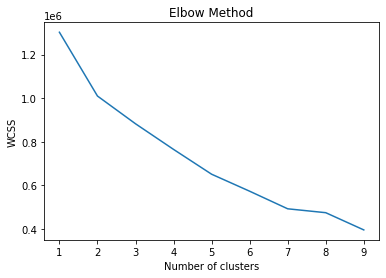

In [117]:
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

8 cluster will be used

In [118]:
df_merged.head(1)

,sessionid,time_movement,event_type,channel,buyingcategoryid,event_type_higher,max_navigation_number,android native_account_info,android native_addtocart,android native_basket_view,android native_campaigns,android native_category_list,android native_claim_tracking,android native_dealofday,android native_destek_taleplerim,android native_efsaneler_klubu,android native_exit,android native_external_access,android native_hepsi_express,android native_home,android native_my_gift_cheques,android native_my_product_comments,android native_mylist,android native_order_result,android native_ordertracking,android native_product_list_brand,android native_product_list_category,android native_product_list_merchant,android native_product_list_search,android native_product_list_tag,android native_product_view,android native_solution_center,android native_wallet_view,desktop_account_info,desktop_addtocart,desktop_basket_view,desktop_campaigns,desktop_claim_tracking,desktop_dealofday,desktop_destek_taleplerim,desktop_efsaneler_klubu,desktop_exit,desktop_home,desktop_my_gift_cheques,desktop_my_product_comments,desktop_mylist,desktop_order_result,desktop_ordertracking,desktop_product_compare,desktop_product_list_brand,desktop_product_list_category,desktop_product_list_merchant,desktop_product_list_search,desktop_product_list_tag,desktop_product_view,desktop_solution_center,desktop_wallet_view,ios native_account_info,ios native_addtocart,ios native_basket_view,ios native_campaigns,ios native_category_list,ios native_dealofday,ios native_destek_taleplerim,ios native_efsaneler_klubu,ios native_exit,ios native_external_access,ios native_hepsi_express,ios native_home,ios native_my_product_comments,ios native_mylist,ios native_order_result,ios native_ordertracking,ios native_product_list_brand,ios native_product_list_category,ios native_product_list_merchant,ios native_product_list_search,ios native_product_list_tag,ios native_product_view,ios native_solution_center,ios native_wallet_view,mobile_account_info,mobile_addtocart,mobile_basket_view,mobile_campaigns,mobile_claim_tracking,mobile_dealofday,mobile_destek_taleplerim,mobile_efsaneler_klubu,mobile_exit,mobile_home,mobile_my_gift_cheques,mobile_my_product_comments,mobile_mylist,mobile_order_result,mobile_ordertracking,mobile_product_list_brand,mobile_product_list_category,mobile_product_list_merchant,mobile_product_list_search,mobile_product_list_tag,mobile_product_view,mobile_solution_center,mobile_wallet_view,term_no_3_nunique,term_no_6_nunique,80087001.0,80089001.0,80089002.0,80089003.0,80089005.0,80089006.0,80089007.0,80089008.0,80089009.0,80089012.0,80089013.0,80089017.0,80089018.0,80089019.0,80089020.0,80089022.0,80089023.0,80089024.0,80089025.0,80089026.0,80089030.0,80089032.0,80089036.0,80089037.0,80320450.0,80756015.0,80758002.0,80758003.0,80758007.0,80758008.0,80758009.0,80758011.0,80758012.0,80822005.0,nan
0,00000221-c499-4158-967d-cf8efe956e66,visivisivisivisivisivisivisibuyyvisivisivisivi...,0.111883,-0.018712,0.854634,6,-0.185673,-0.043597,-0.347875,3.816256,-0.250523,-0.151264,-0.058905,-0.02547,-0.026999,-0.035369,0.197715,-0.356831,-0.120273,0.89313,-0.005302,-0.018998,-0.19497,1.752876,0.883822,-0.104326,-0.181938,-0.128117,-0.34461,-0.276514,0.923835,-0.034963,-0.149652,-0.058568,-0.254703,-0.281845,-0.018717,-0.04077,-0.022903,-0.033276,-0.031346,-0.366443,-0.196363,-0.05346,-0.016282,-0.045662,-0.238859,-0.1844,-0.01463,-0.061485,-0.175545,-0.091237,-0.219228,-0.08395,-0.385162,-0.031046,-0.079296,-0.007553,-0.283738,-0.368928,-0.148273,-0.11195,-0.018162,-0.018146,-0.021046,-0.3724,-0.118655,-0.095294,-0.413196,-0.010197,-0.122777,-0.30662,-0.20111,-0.078905,-0.126873,-0.098876,-0.247777,-0.192548,-0.373318,-0.017013,-0.022545,-0.020841,-0.157637,-0.205961,-0.014147,-0.041665,-0.010293,-0.013005,-0.036757,-0.352791,-0.121869,-0.030097,-0.007236,-0.123963,-0.150867,-0.096725,-0.041854,-0.158475,-0.050903,-0.152286,-0.060261,-0.299091,-0.02494,-0.039563,3.815536,5.365079,-0.062649,

In [119]:
df_merged_a = df_merged.copy()

In [120]:
cluster_values = res_pca.values

In [121]:
model = KPrototypes(n_clusters=8, verbose=2, max_iter=2, n_init=5, random_state=47).fit(cluster_values, categorical=idx)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/2, moves: 9350, ncost: 507718.24753913586
Run: 1, iteration: 2/2, moves: 1609, ncost: 504285.3466476626
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/2, moves: 14333, ncost: 520254.04460160894
Run: 2, iteration: 2/2, moves: 3340, ncost: 484288.256564729
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/2, moves: 13836, ncost: 502292.2495403206
Run: 3, iteration: 2/2, moves: 4851, ncost: 476468.4123972903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/2, moves: 15042, ncost: 531544.705302012
Run: 4, iteration: 2/2, moves: 5710, ncost: 473925.0001801697
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/2, moves: 11394, ncost: 486971.01429045486
Run: 5, iteration: 2/2, moves: 1712, 

In [124]:
df_merged_a['labels'] = model.labels_

In [125]:
df_merged_a.head()

,sessionid,time_movement,event_type,channel,buyingcategoryid,event_type_higher,max_navigation_number,android native_account_info,android native_addtocart,android native_basket_view,android native_campaigns,android native_category_list,android native_claim_tracking,android native_dealofday,android native_destek_taleplerim,android native_efsaneler_klubu,android native_exit,android native_external_access,android native_hepsi_express,android native_home,android native_my_gift_cheques,android native_my_product_comments,android native_mylist,android native_order_result,android native_ordertracking,android native_product_list_brand,android native_product_list_category,android native_product_list_merchant,android native_product_list_search,android native_product_list_tag,android native_product_view,android native_solution_center,android native_wallet_view,desktop_account_info,desktop_addtocart,desktop_basket_view,desktop_campaigns,desktop_claim_tracking,desktop_dealofday,desktop_destek_taleplerim,desktop_efsaneler_klubu,desktop_exit,desktop_home,desktop_my_gift_cheques,desktop_my_product_comments,desktop_mylist,desktop_order_result,desktop_ordertracking,desktop_product_compare,desktop_product_list_brand,desktop_product_list_category,desktop_product_list_merchant,desktop_product_list_search,desktop_product_list_tag,desktop_product_view,desktop_solution_center,desktop_wallet_view,ios native_account_info,ios native_addtocart,ios native_basket_view,ios native_campaigns,ios native_category_list,ios native_dealofday,ios native_destek_taleplerim,ios native_efsaneler_klubu,ios native_exit,ios native_external_access,ios native_hepsi_express,ios native_home,ios native_my_product_comments,ios native_mylist,ios native_order_result,ios native_ordertracking,ios native_product_list_brand,ios native_product_list_category,ios native_product_list_merchant,ios native_product_list_search,ios native_product_list_tag,ios native_product_view,ios native_solution_center,ios native_wallet_view,mobile_account_info,mobile_addtocart,mobile_basket_view,mobile_campaigns,mobile_claim_tracking,mobile_dealofday,mobile_destek_taleplerim,mobile_efsaneler_klubu,mobile_exit,mobile_home,mobile_my_gift_cheques,mobile_my_product_comments,mobile_mylist,mobile_order_result,mobile_ordertracking,mobile_product_list_brand,mobile_product_list_category,mobile_product_list_merchant,mobile_product_list_search,mobile_product_list_tag,mobile_product_view,mobile_solution_center,mobile_wallet_view,term_no_3_nunique,term_no_6_nunique,80087001.0,80089001.0,80089002.0,80089003.0,80089005.0,80089006.0,80089007.0,80089008.0,80089009.0,80089012.0,80089013.0,80089017.0,80089018.0,80089019.0,80089020.0,80089022.0,80089023.0,80089024.0,80089025.0,80089026.0,80089030.0,80089032.0,80089036.0,80089037.0,80320450.0,80756015.0,80758002.0,80758003.0,80758007.0,80758008.0,80758009.0,80758011.0,80758012.0,80822005.0,nan,NEW_COLUMN,labels
0,00000221-c499-4158-967d-cf8efe956e66,visivisivisivisivisivisivisibuyyvisivisivisivi...,0.111883,-0.018712,0.854634,6,-0.185673,-0.043597,-0.347875,3.816256,-0.250523,-0.151264,-0.058905,-0.02547,-0.026999,-0.035369,0.197715,-0.356831,-0.120273,0.893130,-0.005302,-0.018998,-0.19497,1.752876,0.883822,-0.104326,-0.181938,-0.128117,-0.344610,-0.276514,0.923835,-0.034963,-0.149652,-0.058568,-0.254703,-0.281845,-0.018717,-0.04077,-0.022903,-0.033276,-0.031346,-0.366443,-0.196363,-0.05346,-0.016282,-0.045662,-0.238859,-0.1844,-0.01463,-0.061485,-0.175545,-0.091237,-0.219228,-0.08395,-0.385162,-0.031046,-0.079296,-0.007553,-0.283738,-0.368928,-0.148273,-0.11195,-0.018162,-0.018146,-0.021046,-0.372400,-0.118655,-0.095294,-0.413196,-0.010197,-0.122777,-0.30662,-0.201110,-0.078905,-0.126873,-0.098876,-0.247777,-0.192548,-0.373318,-0.017013,-0.022545,-0.020841,-0.157637,-0.205961,-0.014147,-0.041665,-0.010293,-0.013005,-0.036757,-0.352791,-0.121869,-0.030097,-0.007236,-0.123963,-0.150867,-0.096725,-0.041854,-0.158475,-0.050903,-0.152286,-0.060261,-0.299091,-0.02494,-0.039563,3.815